# Modeling the RNA Polymerases in COBRAme

## 1. Load the python packages

In [1]:
from __future__ import print_function, division, absolute_import

# python imports
import re
from os.path import join
from collections import defaultdict
import pickle
import pandas as pd

# third party imports
import pandas
import tabulate
import cobra
pd.set_option('display.max_columns', 100)
pd.set_option('display.width',100)
pd.set_option('display.max_colwidth',100)

# ECOLIme
import ecolime
from ecolime import (transcription, translation, flat_files, generics, formulas, compartments)

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
#from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/solvers/__init__.py:63: UserWarning: No LP solvers found
  warn("No LP solvers found")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


## 2. Load the iJL1678b model

Load the iJL1678b model in pickle format that is located in the current directory.

In [2]:
with open('iJL1678b.pickle', 'rb') as f:
    me = pickle.load(f)

## 3. Solve the model

In [3]:
def solve_me_model(me, max_mu, precision=1e-6, min_mu=0, using_soplex=False,
                  compiled_expressions=None):
    if using_soplex:
        from cobrame.solve.algorithms import binary_search
        binary_search(me, min_mu=min_mu, max_mu=max_mu, debug=True, mu_accuracy=precision,
                      compiled_expressions=compiled_expressions)
    else:
        from qminospy.me1 import ME_NLP1
        # The object containing solveME methods--composite that uses a ME model object 
        me_nlp = ME_NLP1(me, growth_key='mu')
        # Use bisection for now (until the NLP formulation is worked out)
        muopt, hs, xopt, cache = me_nlp.bisectmu(precision=precision, mumax=max_mu)
        me.solution.f = me.solution.x_dict['biomass_dilution']
        
def show_escher_map(me, solution=None):
    import escher
    view = escher.Builder("iJO1366.Central metabolism")
    view.reaction_data = me.get_metabolic_flux(solution=solution)
    return view

In [4]:
solve_me_model(me, 1., min_mu = .1, precision=1e-2, using_soplex=False)

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 82.955696 seconds
Finished substituting S,lb,ub in 6.062509 seconds
Finished makeME_LP in 1.099975 seconds
Getting MINOS parameters from ME_NLP...
1 0.5 0.5 1.0 0.5 optimal
Finished substituting S,lb,ub in 6.940928 seconds
Finished makeME_LP in 0.972956 seconds
Getting MINOS parameters from ME_NLP...
2 0.75 0.75 1.0 0.75 optimal
Finished substituting S,lb,ub in 6.379122 seconds
Finished makeME_LP in 1.037390 seconds
Getting MINOS parameters from ME_NLP...
3 0.75 0.75 0.875 0.875 1
Finished substituting S,lb,ub in 6.677761 seconds
Finished makeME_LP in 1.139712 seconds
Getting MINOS parameters from ME_NLP...
4 0.8125 0.8125 0.875 0.8125 optimal
Finished substituting S,lb,ub in 6.852218 seconds
Finished makeME_LP in 1.033054 seconds
Getting MINOS parameters from ME_NLP...
5 0.8125 0.8125 0.84375 0.84375 1
Finished substituting S,lb,ub in 7.060826 seconds
Finished makeME_LP in 1.008357 seconds
Getting MINOS pa

## 4. Finding the reactions that produce the RNAP (ComplexFormation)

Below is a diagram that outlines the assembly of the iJL1678b-ME ECOLIme RNA polymerases. As you will see, instead of using only one type of RNA polymerase (RNAP) as found in *E.coli* that requires specific $\sigma$ factors to bind to the DNA, this model creates a separate RNAP metabolite representing the RNAP plus a specific $\sigma$ factor. The result is there are seven different RNAP metabolites.

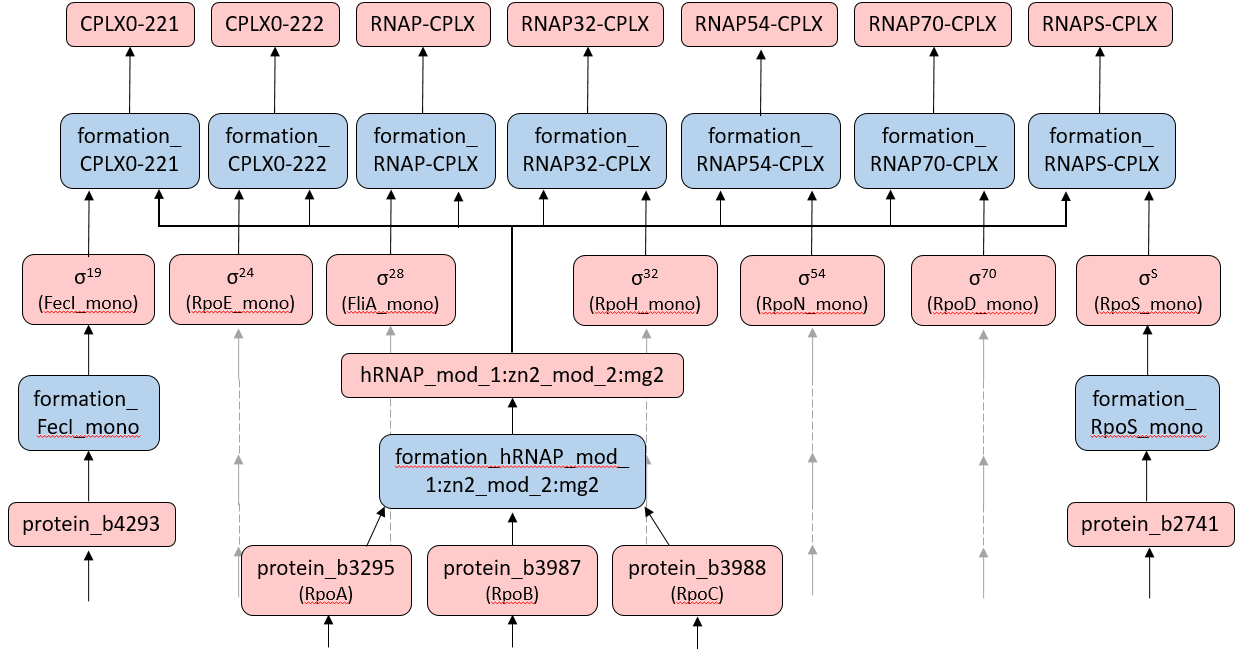

There are seven different RNAPs supported by the iJL1678b-ME ECOLIme model, they include;

1. CPLX0-221: RNA polymerase with the $\sigma$<sup>19</sup> sigma factor (https://www.ecocyc.org/ECOLI/NEW-IMAGE?type=ENZYME&object=CPLX0-221)
    - RpoA (b3295), RpoB (b3987), RpoC (b3988), FecI (b4293)
    

2. RNAPE-CPLX: RNA polymerase with the $\sigma$<sup>24</sup> sigma factor (https://www.ecocyc.org/ECOLI/NEW-IMAGE?type=ENZYME&object=RNAPE-CPLX)
    - RpoA (b3295), RpoB (b3987), RpoC (b3988), RpoE (b2573)
    
    
3. CPLX0-222: RNA polymerase with the $\sigma$<sup>28</sup> sigma factor (https://www.ecocyc.org/ECOLI/NEW-IMAGE?type=ENZYME&object=CPLX0-222)
    - RpoA (b3295), RpoB (b3987), RpoC (b3988), FliA (b1922)
    
    
4. RNAP32-CPLX: RNA polymerase with the $\sigma$<sup>32</sup> sigma factor (https://www.ecocyc.org/ECOLI/NEW-IMAGE?type=ENZYME&object=RNAP32-CPLX)
    - RpoA (b3295), RpoB (b3987), RpoC (b3988), RpoH (b3461)
    
    
5. RNAP54-CPLX: RNA polymerase with the $\sigma$<sup>54</sup> sigma factor (https://www.ecocyc.org/ECOLI/NEW-IMAGE?type=ENZYME&object=RNAP54-CPLX)
    - RpoA (b3295), RpoB (b3987), RpoC (b3988), RpoN (b3202)
    
    
6. RNAP70-CPLX: RNA polymerase with the $\sigma$<sup>70</sup> sigma factor (https://www.ecocyc.org/ECOLI/NEW-IMAGE?type=ENZYME&object=RNAP70-CPLX)
    - RpoA (b3295), RpoB (b3987), RpoC (b3988), RpoD (b3067)
    
    
7. RNAPS-CPLX: RNA polymerase with the $\sigma$<sup>S</sup> sigma factor (https://www.ecocyc.org/ECOLI/NEW-IMAGE?type=ENZYME&object=RNAPS-CPLX)
    - RpoA (b3295), RpoB (b3987), RpoC (b3988), RpoS (b2741)

The specialized *E.coli* sigma factors include (https://golifescience.com/rna-polymerase/)

1. $\sigma$<sup>19</sup>  (FecI): The ferric citrate sigma factor, regulates the FEC gene for iron transport
2. $\sigma$<sup>24</sup> (RpoE): The extracytoplasmic/extreme heat stress sigma factor
3. $\sigma$<sup>28</sup> (FliA or RpoF): the flagellar sigma factor
4. $\sigma$<sup>32</sup> (RpoH): the heat shock sigma factor, it is turned on when the bacteria are exposed to heat. D
5. $\sigma$<sup>54</sup> (RpoN): the nitrogen-limitation sigma factor
6. $\sigma$<sup>70</sup> (RpoD): The primary sigma factor that transcribes most genes in growing cells.
7. $\sigma$<sup>S</sup> (RpoS): the starvation/stationary phase sigma factor

### 4.1 RNAP70-CPLX Assembly

Let's work backwards from the RNAP70-CPLX metabolite to it's DNA and explore how is is created.

In [5]:
me.metabolites.get_by_id('RNAP70-CPLX').reactions

frozenset({<TranscriptionReaction transcription_TU0_2741_from_RpoD_mono at 0x7f83e6b60080>,
           <TranscriptionReaction transcription_TU0_14272_from_RpoD_mono at 0x7f83e71800b8>,
           <TranscriptionReaction transcription_TU00198_from_RpoD_mono at 0x7f83e6f40128>,
           <TranscriptionReaction transcription_TU00378_with_TERM65_from_RpoD_mono at 0x7f83e71c01d0>,
           <TranscriptionReaction transcription_TU0_13855_from_RpoD_mono at 0x7f83e7080240>,
           <TranscriptionReaction transcription_TU795_from_RpoD_mono at 0x7f83e71802e8>,
           <TranscriptionReaction transcription_TU0_13127_from_RpoD_mono at 0x7f83e6b60320>,
           <TranscriptionReaction transcription_TU00170_with_TERM0_1033_from_RpoD_mono at 0x7f83e71c0390>,
           <TranscriptionReaction transcription_TU0_36413_from_RpoD_mono at 0x7f83e7080400>,
           <TranscriptionReaction transcription_TU00520_from_RpoD_mono at 0x7f83e6f404a8>,
           <TranscriptionReaction transcription_TU00227

From this list the 'RNAP70-CPLX' producing reaction is the "ComplexFormation" reaction named "formation_RNAP70-CPLX".

The reactants that are used to produce the RNAP metabolite are 'RNAP70-CPLX'

In [6]:
me.reactions.get_by_id('formation_RNAP70-CPLX').reactants

[<Complex RpoD_mono at 0x7f83e298c2e8>,
 <Complex hRNAP_mod_1:zn2_mod_2:mg2 at 0x7f83e281e1d0>]

#### 4.1.1. RpoD_mono Assembly Example

The first of these reactants, "RpoD_mono," is the "Complex" metabolite name for $\sigma$<sup>70</sup>.

The second "Complex" metabolite "hRNAP_mod_1:zn2_mod_2:mg2" corresponds to the generic $\sigma$-less RNAP.

to start with let's follow the creation path of "RpoD_mono"

In [7]:
me.metabolites.get_by_id('RpoD_mono').reactions

frozenset({<ComplexFormation formation_RNAP70-CPLX at 0x7f83e10389e8>,
           <ComplexFormation formation_RpoD_mono at 0x7f83e298c2b0>})

From this we can deduce that it is created by the "ComplexFormation" reaction "formation_RpoD_mono."

examining the reactants of the "ComplexFormation" reaction "formation_RpoD_mono" gives

In [8]:
me.reactions.get_by_id('formation_RpoD_mono').reactants

[<TranslatedGene protein_b3067 at 0x7f83e4086128>]

Thus, we can see that "ComplexFormation" reaction "formation_RpoD_mono" only reactant was the "TranslatedGene" metabolite "protein_b3067".

Now taking the final step, let's identify the "TranslationReaction" that produces the protein.

In [9]:
me.metabolites.get_by_id('protein_b3067').reactions

frozenset({<ComplexFormation formation_RpoD_mono at 0x7f83e298c2b0>,
           <TranslationReaction translation_b3067 at 0x7f83e40f0be0>})

From this we can see that it was the "TranslationReaction" reaction named "translation_b3067" that produces the "TranslatedGene" metabolite "protein_b3067". 

So what are the reactants for this translation reaction

In [10]:
me.reactions.get_by_id('translation_b3067').reactants

[<Metabolite met__L_c at 0x7f83e6778908>,
 <Metabolite h2o_c at 0x7f83e747b9e8>,
 <Metabolite glu__L_c at 0x7f83e6786048>,
 <Metabolite gln__L_c at 0x7f83e6786208>,
 <Metabolite asn__L_c at 0x7f83e6778f98>,
 <Metabolite pro__L_c at 0x7f83e6786278>,
 <Metabolite ser__L_c at 0x7f83e6778e48>,
 <Metabolite leu__L_c at 0x7f83e6778ac8>,
 <Metabolite lys__L_c at 0x7f83e6778c18>,
 <Metabolite val__L_c at 0x7f83e6778b00>,
 <Metabolite thr__L_c at 0x7f83e6778da0>,
 <Metabolite arg__L_c at 0x7f83e6778a20>,
 <Metabolite gly_c at 0x7f83e6778c88>,
 <Metabolite tyr__L_c at 0x7f83e6786400>,
 <Metabolite ala__L_c at 0x7f83e6778ef0>,
 <Metabolite asp__L_c at 0x7f83e67860f0>,
 <Metabolite his__L_c at 0x7f83e6786320>,
 <Metabolite ile__L_c at 0x7f83e6786198>,
 <Metabolite cys__L_c at 0x7f83e6786390>,
 <Metabolite phe__L_c at 0x7f83e6778c50>,
 <Metabolite trp__L_c at 0x7f83e6786470>,
 <Ribosome ribosome at 0x7f83e67864e0>,
 <TranscribedGene RNA_b3067 at 0x7f83e732f828>,
 <Metabolite atp_c at 0x7f83e747b908

From this data the mRNA metabolite is the "TranscribedGene" "RNA_b3067"

#### 4.1.2 Generic RNAP (hRNAP_mod_1:zn2_mod_2:mg2) Assembly Example

Let's begin by looking at the reactions associated with the'hRNAP_mod_1:zn2_mod_2:mg2' metabolite.

In [11]:
me.metabolites.get_by_id('hRNAP_mod_1:zn2_mod_2:mg2').reactions

frozenset({<ComplexFormation formation_CPLX0-221 at 0x7f83e1038780>,
           <ComplexFormation formation_CPLX0-222 at 0x7f83e1038898>,
           <ComplexFormation formation_RNAP32-CPLX at 0x7f83e1038908>,
           <ComplexFormation formation_RNAP54-CPLX at 0x7f83e1038978>,
           <ComplexFormation formation_RNAP70-CPLX at 0x7f83e10389e8>,
           <ComplexFormation formation_RNAPE-CPLX at 0x7f83e1038860>,
           <ComplexFormation formation_RNAPS-CPLX at 0x7f83e1038a58>,
           <ComplexFormation formation_hRNAP_mod_1:zn2_mod_2:mg2 at 0x7f83e281e198>})

From this data we can see that the 'hRNAP_mod_1:zn2_mod_2:mg2' metabolite is a reactant for all the RNAP formation reactions.

We can also see that it is formed by the "ComplexFormation" reaction named "formation_hRNAP_mod_1:zn2_mod_2:mg2"

The reactants required by the "formation_hRNAP_mod_1:zn2_mod_2:mg2" reaction to create the 'hRNAP_mod_1:zn2_mod_2:mg2' metabolite are

In [12]:
me.reactions.get_by_id('formation_hRNAP_mod_1:zn2_mod_2:mg2').reactants

[<TranslatedGene protein_b3988 at 0x7f83e33bc080>,
 <TranslatedGene protein_b3295 at 0x7f83e3e41e10>,
 <TranslatedGene protein_b3987 at 0x7f83e34259b0>,
 <Metabolite zn2_c at 0x7f83e29afbe0>,
 <Metabolite mg2_c at 0x7f83e29af1d0>]

The details of these "TranslatedGenes" metabolites are

- protein_b3295 (RpoA): RNA polymerase subunit α  (https://www.ecocyc.org/gene?orgid=ECOLI&id=EG10893)
- protein_b3987 (RpoB): RNA polymerase subunit β  (https://www.ecocyc.org/gene?orgid=ECOLI&id=EG10894)
- protein_b3988 (RpoC): RNA polymerase subunit β' (https://www.ecocyc.org/gene?orgid=ECOLI&id=EG10895)

Note that the "formation_hRNAP_mod_1:zn2_mod_2:mg2" produces the RNAP that does not include the sigma factor.

From this information we can assume that mRNA metabolites that create these TranslatedGenes are

- RNA_b3295 -> protein_b3295 (RpoA)
- RNA_b3987 -> protein_b3987 (RpoB)
- RNA-b3988 -> protein_b3988 (RpoC)

## RNAP Flux

The seven different "ComplexFormation" RNAP reaction complexes that will carry the RNAP metabolite flux are

1. formation_CPLX0-221
2. formation_RNAPE-CPLX
3. formation_CPLX0-222
4. formation_RNAP32-CPLX
5. formation_RNAP54-CPLX
6. formation_RNAP70-CPLX
7. formation_RNAPS-CPLX

The flux through them can be found as follows

In [16]:
import pandas as pd

RNAP_name = []
RNAP_name.append('formation_CPLX0-221')
RNAP_name.append('formation_RNAPE-CPLX')
RNAP_name.append('formation_CPLX0-222')
RNAP_name.append('formation_RNAP32-CPLX')
RNAP_name.append('formation_RNAP54-CPLX')
RNAP_name.append('formation_RNAP70-CPLX')
RNAP_name.append('formation_RNAPS-CPLX')

RNAP_flux = []
RNAP_flux.append(me.reactions.get_by_id('formation_CPLX0-221').x)
RNAP_flux.append(me.reactions.get_by_id('formation_RNAPE-CPLX').x)
RNAP_flux.append(me.reactions.get_by_id('formation_CPLX0-222').x)
RNAP_flux.append(me.reactions.get_by_id('formation_RNAP32-CPLX').x)
RNAP_flux.append(me.reactions.get_by_id('formation_RNAP54-CPLX').x)
RNAP_flux.append(me.reactions.get_by_id('formation_RNAP70-CPLX').x)
RNAP_flux.append(me.reactions.get_by_id('formation_RNAPS-CPLX').x)

data = {"RNAP Flux": RNAP_flux}
df = pd.DataFrame(data, pd.Index(RNAP_name, name='RNAP ComplexFormation Reactions'))
df

,RNAP Flux
RNAP ComplexFormation Reactions,
formation_CPLX0-221,0.000000e+00
formation_RNAPE-CPLX,6.415378e-09
formation_CPLX0-222,1.383282e-08
formation_RNAP32-CPLX,3.582316e-09
formation_RNAP54-CPLX,9.037627e-11
formation_RNAP70-CPLX,4.490595e-06
formation_RNAPS-CPLX,1.408333e-08


Note that the there is no flux through the "formation_CPLX0-221" reaction (ComplexFormation).